# Data Exploration and Feature Engineering

In [1]:
import pandas as pd
import json
import re
import numpy as np

# Import movie lists for feature engineering
from movie_lists import (
    MARVEL_MCU_FILMS, DC_FILMS, STAR_WARS_FILMS, FAST_FURIOUS_FILMS, 
    WIZARDING_WORLD_FILMS, ALL_LIVE_ACTION_REMAKES,
    MEDIA_ADAPTATIONS, ALL_SUPERHERO_FILMS,
    REMAKE_PATTERNS, REMAKE_TITLE_INDICATORS
)

In [2]:
df = pd.read_csv("../data/dataset_domestic_lifetime_merged.csv")

## Top 10 Highest Grossing Movies (US Domestic)

In [3]:
df.nlargest(10, "revenue_domestic")[["title","release_year","revenue_domestic"]].rename(columns={"revenue_domestic":"lifetime_domestic"}).reset_index(drop=True)

,title,release_year,lifetime_domestic
0,Star Wars: The Force Awakens,2015,936662225.0
1,Avengers: Endgame,2019,858373000.0
2,Spider-Man: No Way Home,2021,814866759.0
3,Top Gun: Maverick,2022,718732821.0
4,Black Panther,2018,700426566.0
5,Avatar: The Way of Water,2022,684075767.0
6,Avengers: Infinity War,2018,678815482.0
7,Jurassic World,2015,653406625.0
8,Inside Out 2,2024,652980194.0
9,Deadpool & Wolverine,2024,636745858.0


In [4]:
df.columns

Index(['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'release_date', 'title', 'video', 'vote_average', 'vote_count',
       'release_year', 'genres', 'title_normalized', 'domestic_revenue',
       'rank', 'distributor', 'revenue_domestic', 'revenue'],
      dtype='object')

## Production Companies Analysis

In [5]:
# Check distributor format (our main studio information)
df['distributor'].head(10)

0    Walt Disney Studios Motion Pictures
1                           Warner Bros.
2    Walt Disney Studios Motion Pictures
3                     Universal Pictures
4                  Twentieth Century Fox
5    Walt Disney Studios Motion Pictures
6    Walt Disney Studios Motion Pictures
7                                    NaN
8                  Twentieth Century Fox
9                  The Weinstein Company
Name: distributor, dtype: object

In [6]:
print("Top studios:")
print(df['distributor'].value_counts().head(50))

Top studios:
distributor
Universal Pictures                        164
Warner Bros.                              145
Lionsgate                                 116
Sony Pictures Releasing                   100
Walt Disney Studios Motion Pictures        86
Paramount Pictures                         83
Focus Features                             70
Twentieth Century Fox                      64
A24                                        61
STX Entertainment                          29
Roadside Attractions                       27
Bleecker Street Media                      26
Screen Gems                                22
Open Road Films (II)                       21
Neon                                       21
United Artists Releasing                   20
20th Century Studios                       19
Fox Searchlight Pictures                   15
Vertical Entertainment                     13
Fathom Events                              12
Searchlight Pictures                       11
Angel    

In [7]:
# Studio boolean flags based on distributor
df['is_disney'] = df['distributor'].str.contains('Disney|Walt Disney', case=False, na=False).astype(int)
df['is_warner_bros'] = df['distributor'].str.contains('Warner Bros', case=False, na=False).astype(int)
df['is_universal'] = df['distributor'].str.contains('Universal', case=False, na=False).astype(int)
df['is_sony'] = df['distributor'].str.contains('Sony|Columbia|Screen Gems|TriStar', case=False, na=False).astype(int)
df['is_paramount'] = df['distributor'].str.contains('Paramount', case=False, na=False).astype(int)
df['is_fox'] = df['distributor'].str.contains('Fox|20th Century', case=False, na=False).astype(int)
df['is_mgm'] = df['distributor'].str.contains('MGM|United Artists', case=False, na=False).astype(int)
df['is_lionsgate'] = df['distributor'].str.contains('Lionsgate', case=False, na=False).astype(int)

df['is_major_studio'] = (df['is_disney'] | df['is_warner_bros'] | df['is_universal'] |
                         df['is_sony'] | df['is_paramount'] | df['is_fox'] |
                         df['is_mgm'] | df['is_lionsgate']).astype(int)

print("Studio counts:")
print(f"Disney: {df['is_disney'].sum()}")
print(f"Warner Bros: {df['is_warner_bros'].sum()}")
print(f"Universal: {df['is_universal'].sum()}")
print(f"Sony: {df['is_sony'].sum()}")
print(f"Paramount: {df['is_paramount'].sum()}")
print(f"Fox: {df['is_fox'].sum()}")
print(f"MGM: {df['is_mgm'].sum()}")
print(f"Lionsgate: {df['is_lionsgate'].sum()}")
print(f"Major studio total: {df['is_major_studio'].sum()} ({df['is_major_studio'].mean()*100:.1f}%)")

Studio counts:
Disney: 86
Warner Bros: 145
Universal: 168
Sony: 150
Paramount: 88
Fox: 99
MGM: 39
Lionsgate: 116
Major studio total: 891 (58.2%)


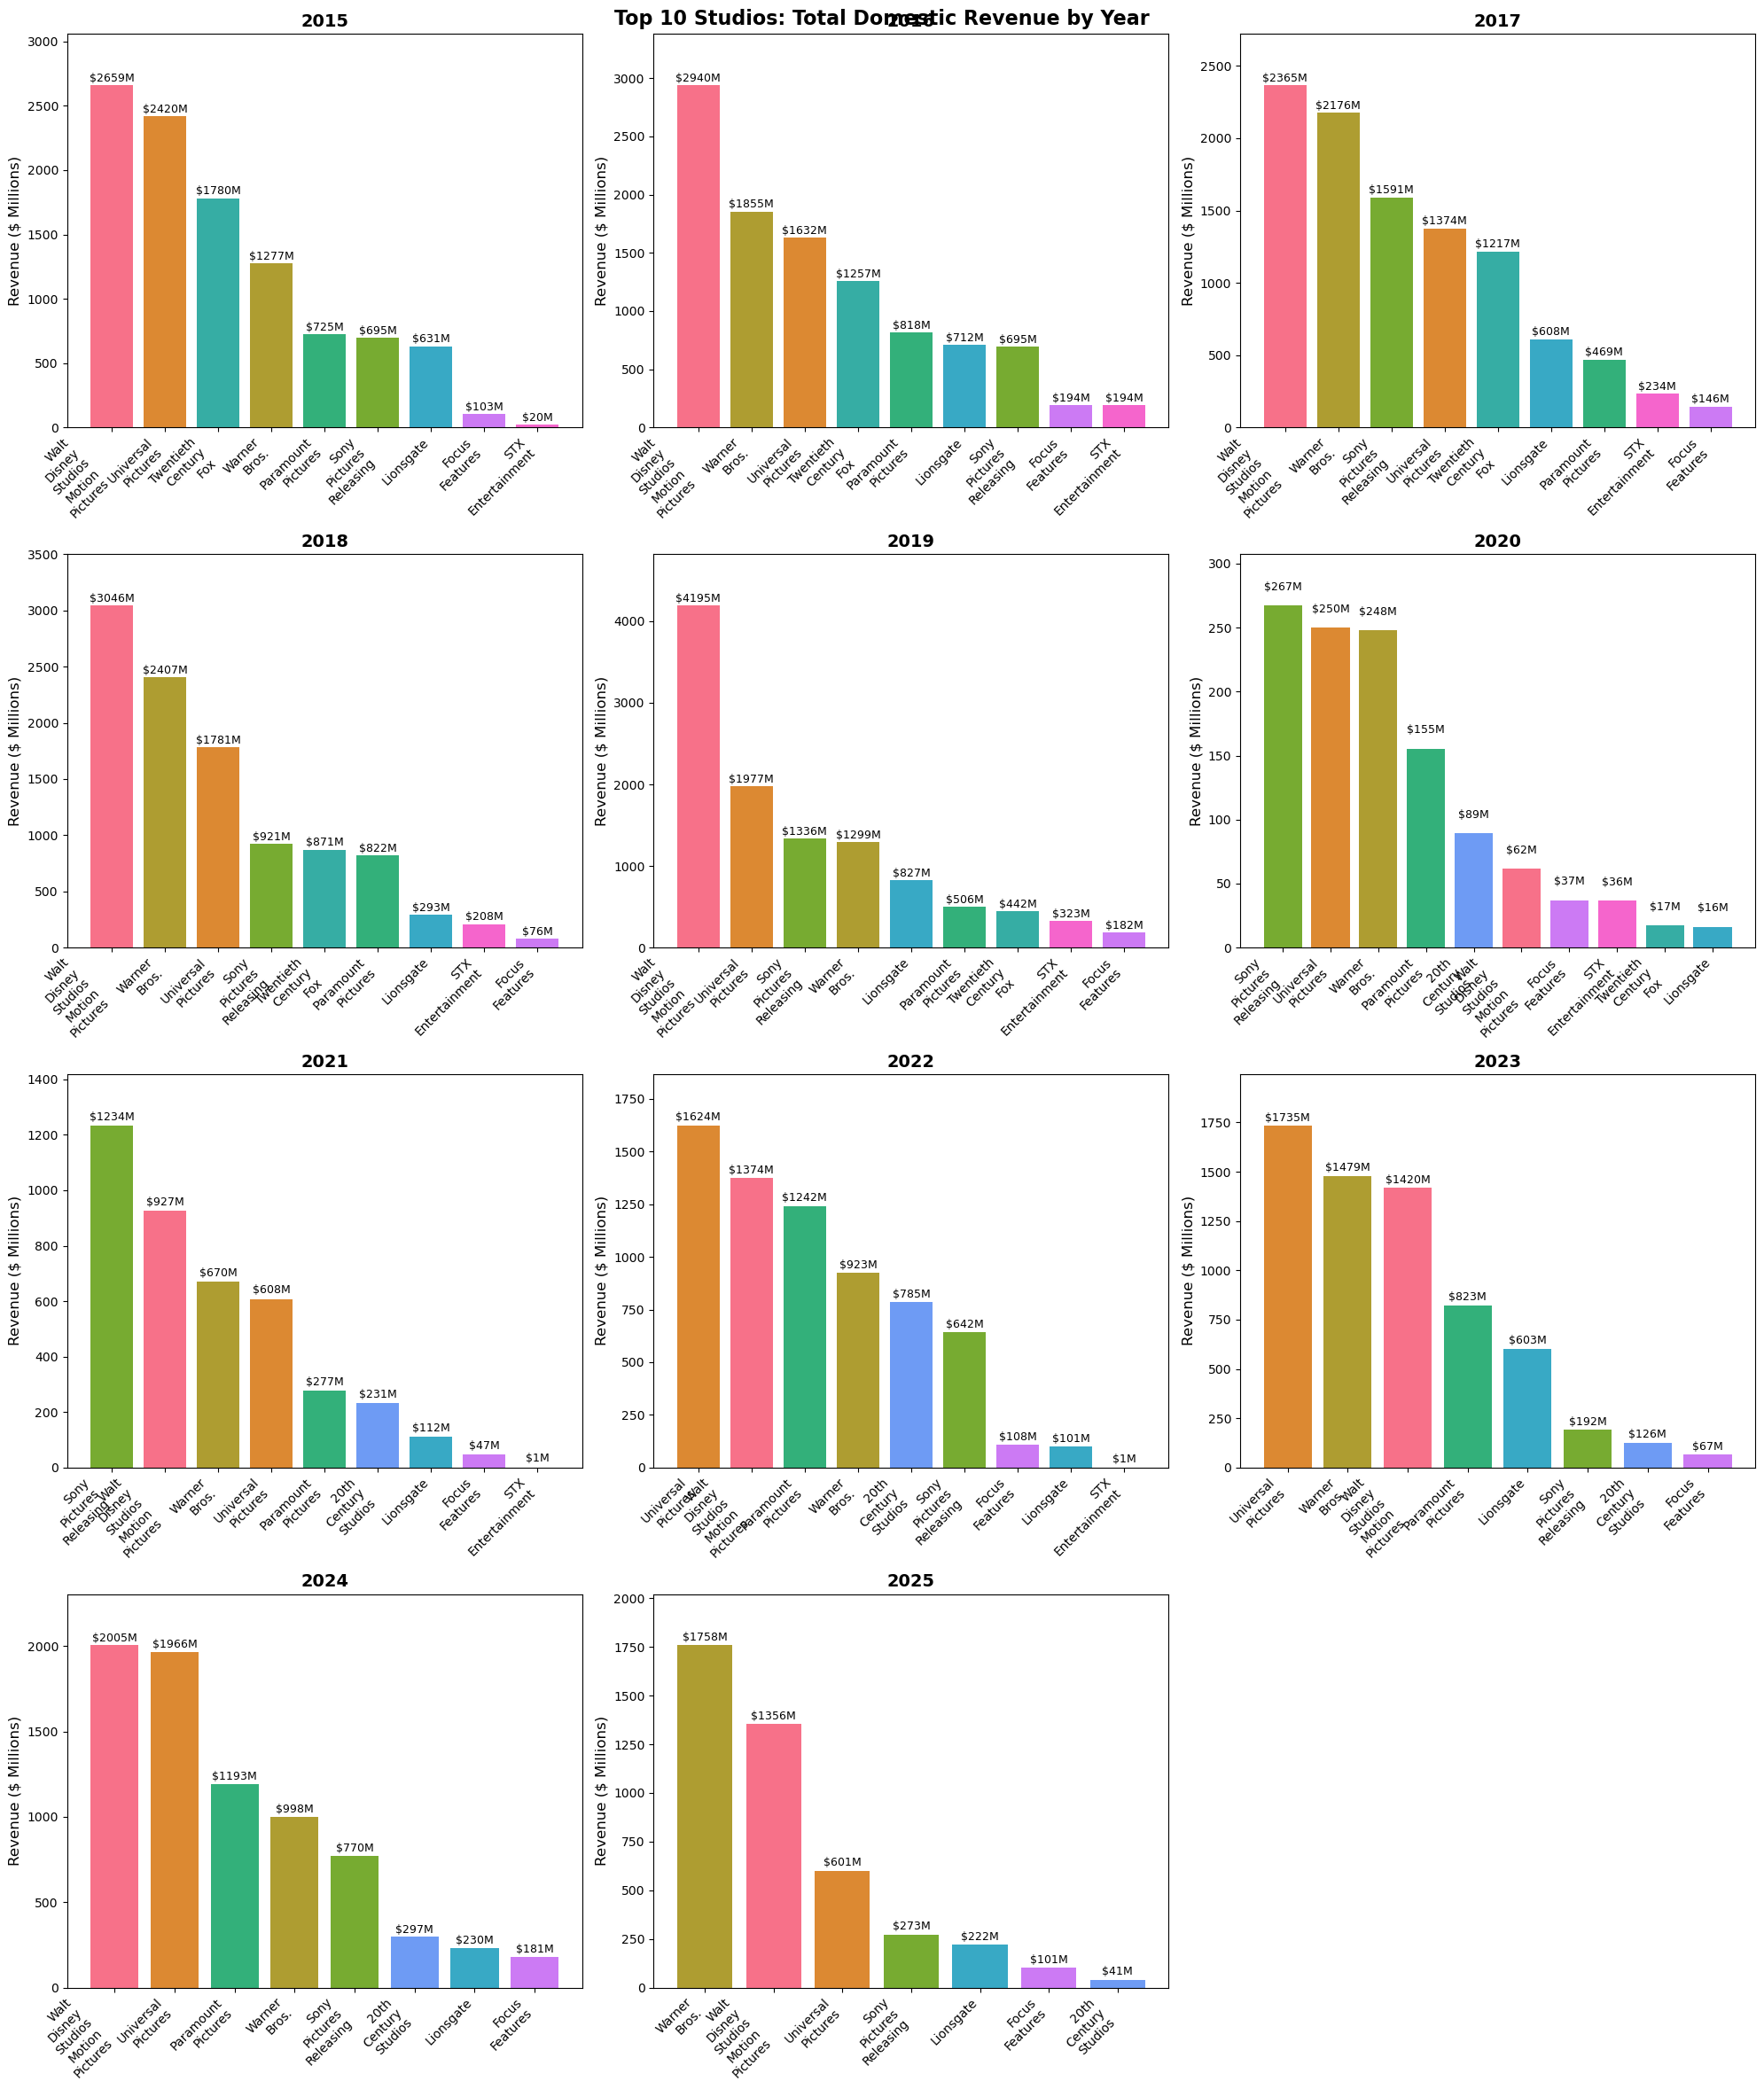


📊 Studio Revenue Analysis (2015-2025):

Top 10 Studios by Total Domestic Revenue:
 1. Walt Disney Studios Motion Pictures $22.35B
 2. Universal Pictures                  $15.97B
 3. Warner Bros.                        $15.09B
 4. Sony Pictures Releasing             $8.62B
 5. Paramount Pictures                  $7.03B
 6. Twentieth Century Fox               $5.59B
 7. Lionsgate                           $4.35B
 8. 20th Century Studios                $1.57B
 9. Focus Features                      $1.24B
10. STX Entertainment                   $1.02B

Years covered: 2015-2025 (11 years)
Total movies analyzed: 1,532
Total domestic revenue: $92.8B


In [8]:
### Studio Revenue by Year Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Get top 10 distributors by total revenue
top_10_distributors = (df.groupby('distributor')['revenue_domestic']
                       .sum()
                       .sort_values(ascending=False)
                       .head(10)
                       .index.tolist())

# Create data for visualization by year
years = sorted(df['release_year'].unique())
studio_revenue_by_year = {}

for year in years:
    year_data = df[df['release_year'] == year]
    
    # Get revenue by distributor for this year, only for top 10
    year_revenue = (year_data[year_data['distributor'].isin(top_10_distributors)]
                    .groupby('distributor')['revenue_domestic']
                    .sum()
                    .reindex(top_10_distributors, fill_value=0))
    
    studio_revenue_by_year[year] = year_revenue

# Create subplots - one per year
n_years = len(years)
cols = 3
rows = (n_years + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
fig.suptitle('Top 10 Studios: Total Domestic Revenue by Year', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
if rows > 1:
    axes = axes.flatten()
elif rows == 1 and cols > 1:
    axes = [axes] if n_years == 1 else axes
else:
    axes = [axes]

# Define colors for consistency across years
colors = sns.color_palette("husl", len(top_10_distributors))
color_map = dict(zip(top_10_distributors, colors))

for i, year in enumerate(years):
    ax = axes[i]
    
    year_revenue = studio_revenue_by_year[year]
    # Only show studios with revenue > 0 for this year
    year_revenue_filtered = year_revenue[year_revenue > 0].sort_values(ascending=False)
    
    if len(year_revenue_filtered) > 0:
        studio_colors = [color_map[studio] for studio in year_revenue_filtered.index]
        
        bars = ax.bar(range(len(year_revenue_filtered)), 
                     year_revenue_filtered.values / 1e6,  # Convert to millions
                     color=studio_colors)
        
        ax.set_title(f'{year}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Revenue ($ Millions)', fontsize=12)
        ax.set_xticks(range(len(year_revenue_filtered)))
        ax.set_xticklabels([studio.replace(' ', '\n') for studio in year_revenue_filtered.index], 
                          rotation=45, ha='right', fontsize=10)
        
        # Add value labels on bars
        for bar, value in zip(bars, year_revenue_filtered.values):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                       f'${value/1e6:.0f}M', ha='center', va='bottom', fontsize=9)
        
        # Set y-axis limit for consistency
        ax.set_ylim(0, max(year_revenue_filtered.max() / 1e6 * 1.15, 100))
        
    else:
        ax.set_title(f'{year} (No Data)', fontsize=14)
        ax.set_ylabel('Revenue ($ Millions)', fontsize=12)

# Hide empty subplots
for i in range(n_years, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Studio Revenue Analysis ({min(years)}-{max(years)}):")
print("=" * 50)

total_revenue_by_studio = df.groupby('distributor')['revenue_domestic'].sum().sort_values(ascending=False)
print("\nTop 10 Studios by Total Domestic Revenue:")
for i, (studio, revenue) in enumerate(total_revenue_by_studio.head(10).items(), 1):
    print(f"{i:2d}. {studio:35s} ${revenue/1e9:.2f}B")

print(f"\nYears covered: {min(years)}-{max(years)} ({len(years)} years)")
print(f"Total movies analyzed: {len(df):,}")
print(f"Total domestic revenue: ${df['revenue_domestic'].sum()/1e9:.1f}B")

## Genre Analysis

In [9]:
# Examine genre data (stored as list in genres column)
print("Exploring genres in the dataset:")

# The genres column contains genre IDs, let's convert them to readable format
# Common TMDb genre ID mappings
genre_map = {
    '28': 'Action',
    '12': 'Adventure',
    '16': 'Animation',
    '35': 'Comedy',
    '80': 'Crime',
    '99': 'Documentary',
    '18': 'Drama',
    '10751': 'Family',
    '14': 'Fantasy',
    '36': 'History',
    '27': 'Horror',
    '10402': 'Music',
    '9648': 'Mystery',
    '10749': 'Romance',
    '878': 'Science Fiction',
    '10770': 'TV Movie',
    '53': 'Thriller',
    '10752': 'War',
    '37': 'Western'
}

# Convert genre IDs to names
def convert_genre_ids(genre_str):
    if pd.isna(genre_str):
        return 'Unknown'
    genre_names = []
    # Remove brackets and split by comma
    genre_str = str(genre_str).strip('[]').replace(' ', '')
    if genre_str:
        genre_ids = genre_str.split(',')
        for gid in genre_ids:
            gid = gid.strip()
            if gid in genre_map:
                genre_names.append(genre_map[gid])
    return ','.join(genre_names) if genre_names else 'Unknown'

df['genre_names'] = df['genres'].apply(convert_genre_ids)

# Split and explode genres to get individual genre counts
genres_exploded = df['genre_names'].str.split(',').explode().str.strip()
unique_genres = genres_exploded.value_counts()

print(f"Total unique genres: {len(unique_genres)}")
print(f"Total genre entries (including duplicates): {len(genres_exploded)}")
print("\nAll genres sorted by frequency:")
print(unique_genres)

Exploring genres in the dataset:
Total unique genres: 18
Total genre entries (including duplicates): 3994

All genres sorted by frequency:
genre_names
Drama              653
Comedy             463
Thriller           407
Action             400
Adventure          341
Horror             283
Science Fiction    213
Family             194
Crime              192
Fantasy            178
Romance            161
Mystery            131
History            124
Animation          124
Music               53
War                 43
Western             19
Unknown             15
Name: count, dtype: int64


In [10]:
# One-hot encode all genres
print("Creating one-hot encoded features for all genres:")

# Get all unique genres from converted names
genres_exploded = df['genre_names'].str.split(',').explode().str.strip()
all_genres = genres_exploded.value_counts().index.tolist()
# Remove 'Unknown' if it exists
all_genres = [g for g in all_genres if g != 'Unknown']

# Create boolean flag for each genre
genre_columns = []
for genre in all_genres:
    col_name = f'genre_{genre.lower().replace(" ", "_").replace("-", "_")}'
    df[col_name] = df['genre_names'].str.contains(genre, case=False, na=False).astype(int)
    genre_columns.append(col_name)

print(f"Created {len(genre_columns)} genre features:")
print("\nGenre feature counts:")
for i, col in enumerate(genre_columns):
    count = df[col].sum()
    original_genre = all_genres[i]
    print(f"{original_genre}: {count}")

print(f"\nGenre columns created: {genre_columns[:10]}..." if len(genre_columns) > 10 else f"\nGenre columns created: {genre_columns}")

Creating one-hot encoded features for all genres:
Created 17 genre features:

Genre feature counts:
Drama: 653
Comedy: 463
Thriller: 407
Action: 400
Adventure: 341
Horror: 283
Science Fiction: 213
Family: 194
Crime: 192
Fantasy: 178
Romance: 161
Mystery: 131
History: 124
Animation: 124
Music: 53
War: 43
Western: 19

Genre columns created: ['genre_drama', 'genre_comedy', 'genre_thriller', 'genre_action', 'genre_adventure', 'genre_horror', 'genre_science_fiction', 'genre_family', 'genre_crime', 'genre_fantasy']...


In [11]:
# Genre combinations using new one-hot encoded features
df['is_action_adventure'] = (df['genre_action'] & df['genre_adventure']).astype(int)
df['is_action_sci_fi'] = (df['genre_action'] & df['genre_science_fiction']).astype(int)
df['is_comedy_romance'] = (df['genre_comedy'] & df['genre_romance']).astype(int)
df['is_family_animation'] = (df['genre_family'] & df['genre_animation']).astype(int)

print("Popular genre combinations:")
print(f"Action + Adventure: {df['is_action_adventure'].sum()}")
print(f"Action + Sci-Fi: {df['is_action_sci_fi'].sum()}")
print(f"Comedy + Romance: {df['is_comedy_romance'].sum()}")
print(f"Family + Animation: {df['is_family_animation'].sum()}")

Popular genre combinations:
Action + Adventure: 178
Action + Sci-Fi: 123
Comedy + Romance: 63
Family + Animation: 111


In [12]:
# Primary genre and genre count
df['primary_genre'] = df['genre_names'].str.split(',').str[0].fillna('Unknown')
df['genre_count'] = df['genre_names'].str.count(',').fillna(-1) + 1

print("Top genres:")
print(df['primary_genre'].value_counts().head(10))
print(f"\nAverage genres per movie: {df['genre_count'].mean():.2f}")
print(f"Max genres in one movie: {df['genre_count'].max()}")

Top genres:
primary_genre
Drama              313
Action             249
Horror             217
Comedy             203
Family              69
Thriller            65
Animation           63
Adventure           60
Science Fiction     56
Crime               52
Name: count, dtype: int64

Average genres per movie: 2.61
Max genres in one movie: 6


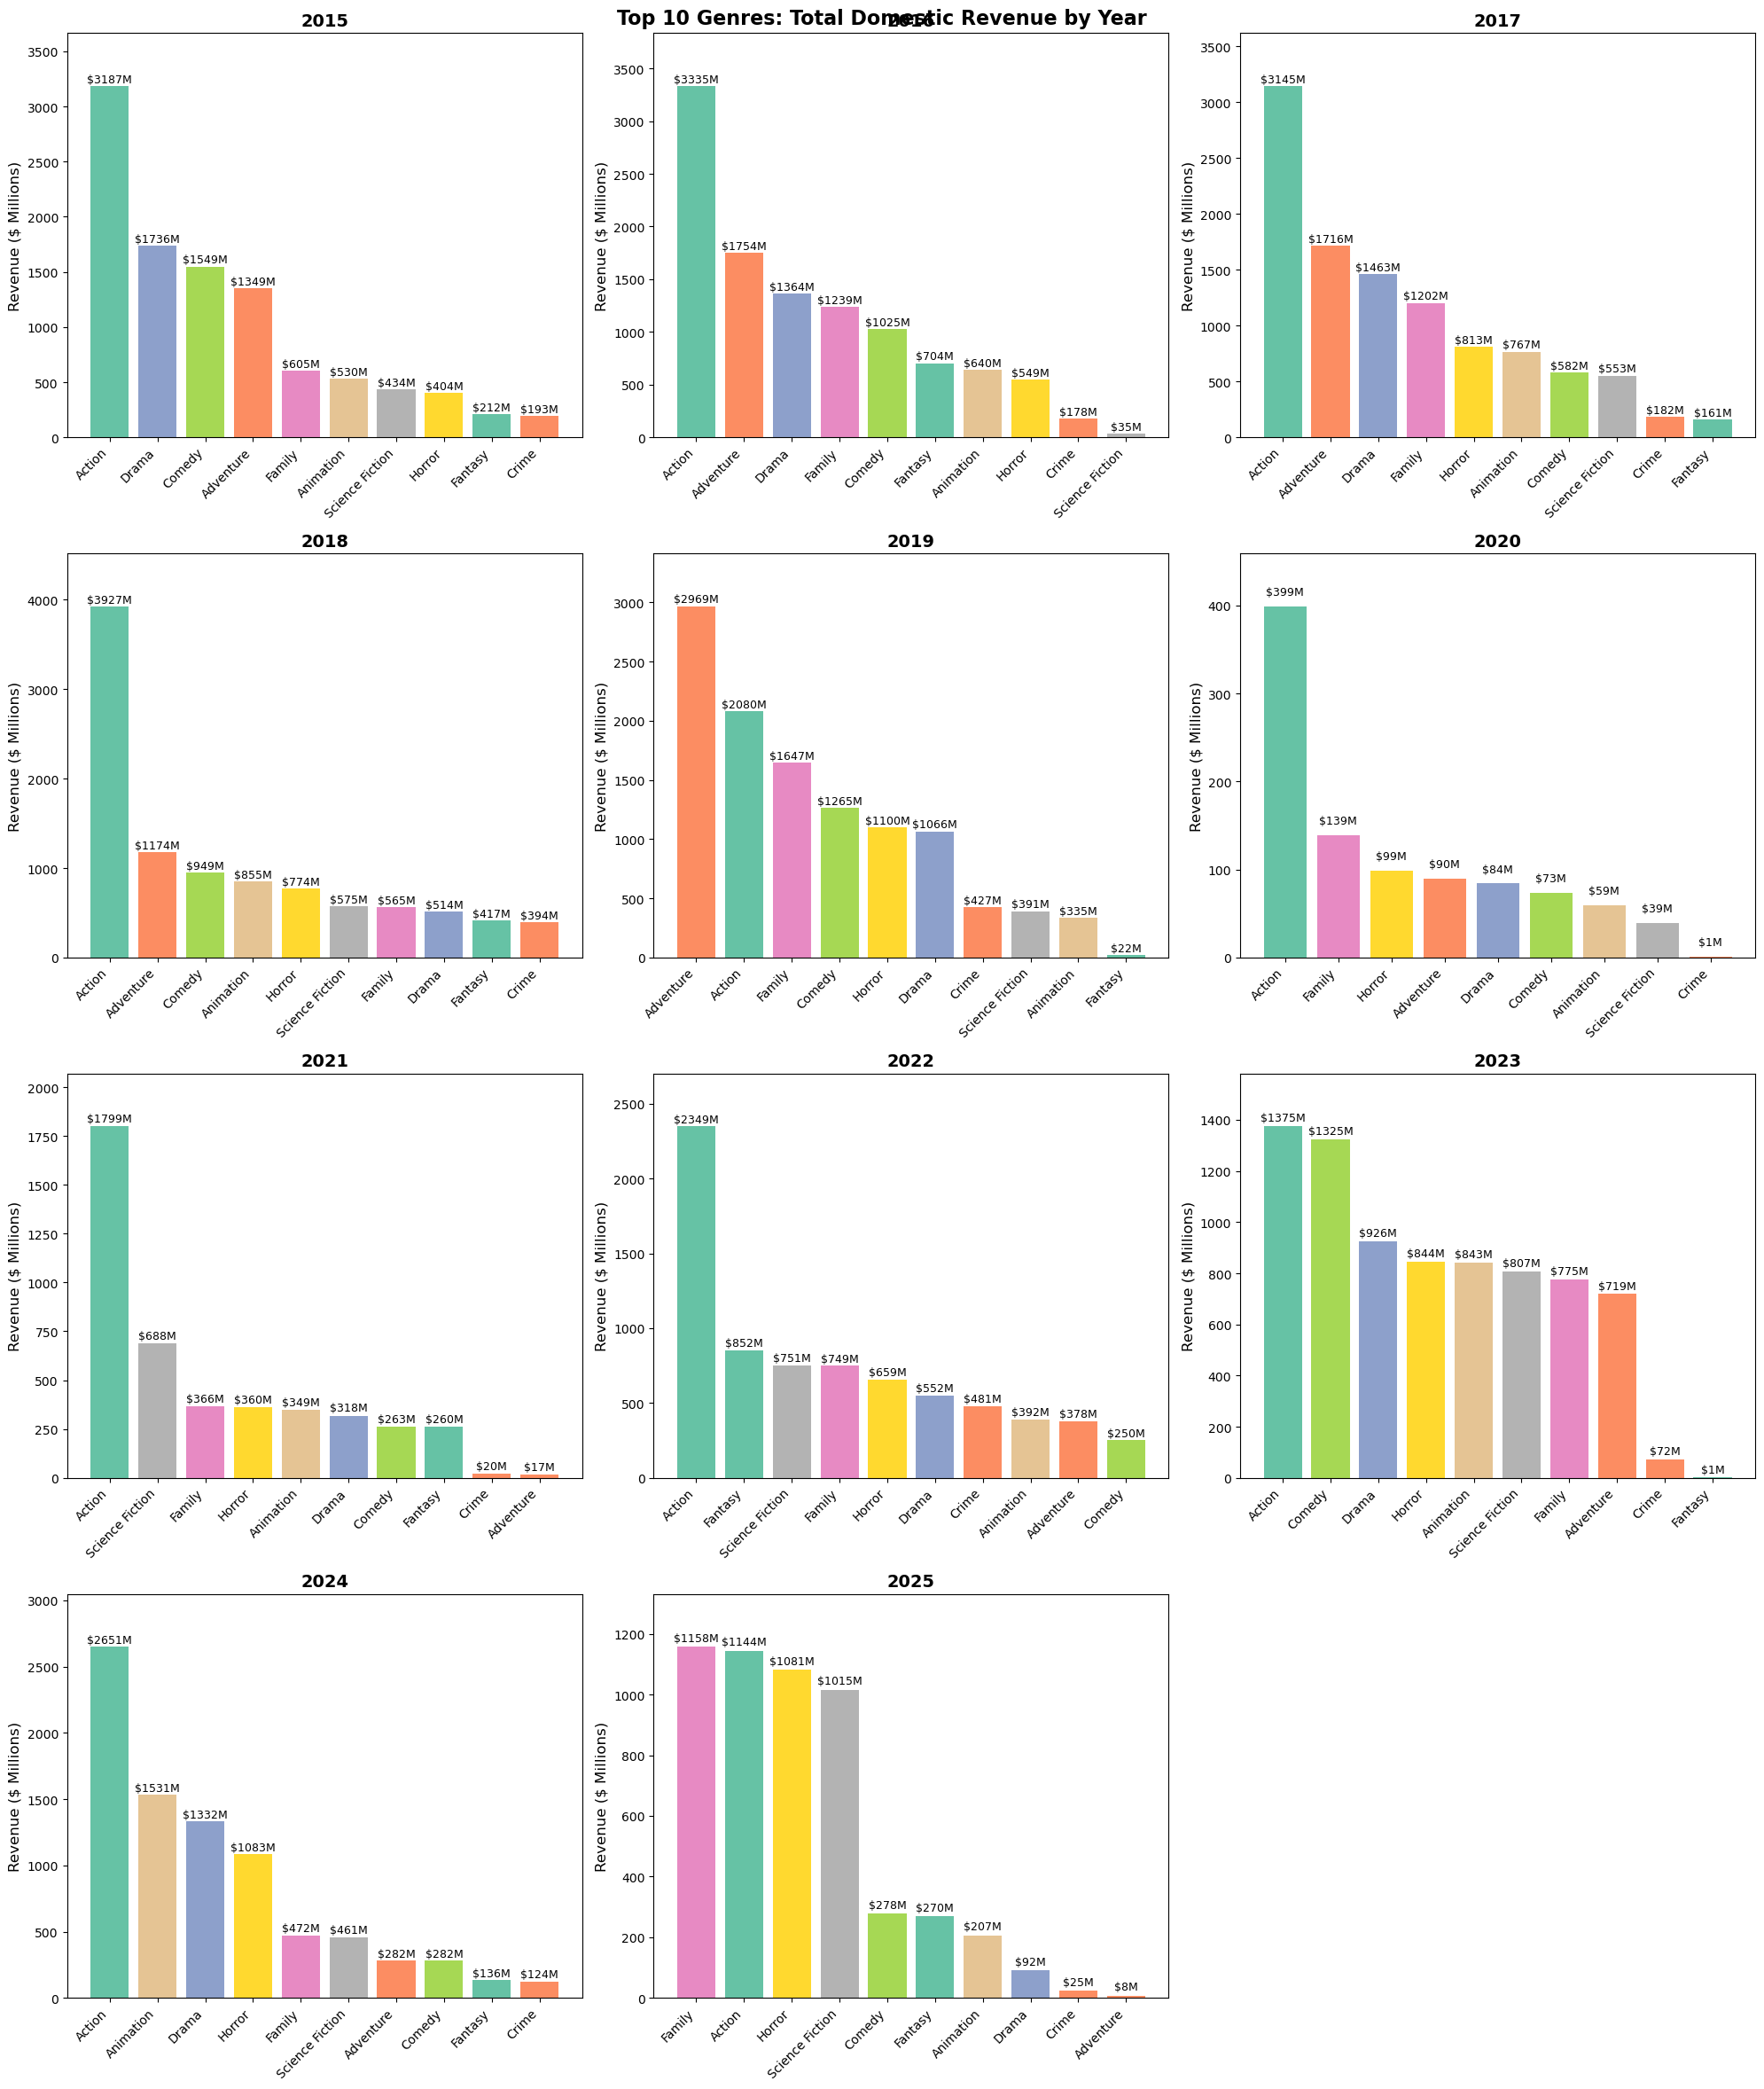


🎬 Genre Revenue Analysis (2015-2025):

Top 10 Genres by Total Domestic Revenue:
 1. Action          $25.39B (249 movies, avg: $102M)
 2. Adventure       $10.46B ( 60 movies, avg: $174M)
 3. Drama           $9.45B (313 movies, avg: $30M)
 4. Family          $8.92B ( 69 movies, avg: $129M)
 5. Comedy          $7.84B (203 movies, avg: $39M)
 6. Horror          $7.77B (217 movies, avg: $36M)
 7. Animation       $6.51B ( 63 movies, avg: $103M)
 8. Science Fiction $5.75B ( 56 movies, avg: $103M)
 9. Fantasy         $3.03B ( 33 movies, avg: $92M)
10. Crime           $2.10B ( 52 movies, avg: $40M)

Genre Performance Insights:
------------------------------
Highest avg revenue: Adventure ($174M avg)
Most movies produced: Drama (313 movies)

Total movies by primary genre: 1,532
Total domestic revenue: $92.8B


In [13]:
### Genre Revenue by Year Visualization

# Get top 10 primary genres by total revenue
top_10_genres = (df.groupby('primary_genre')['revenue_domestic']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10)
                 .index.tolist())

# Create data for visualization by year
years = sorted(df['release_year'].unique())
genre_revenue_by_year = {}

for year in years:
    year_data = df[df['release_year'] == year]
    
    # Get revenue by primary genre for this year, only for top 10
    year_revenue = (year_data[year_data['primary_genre'].isin(top_10_genres)]
                    .groupby('primary_genre')['revenue_domestic']
                    .sum()
                    .reindex(top_10_genres, fill_value=0))
    
    genre_revenue_by_year[year] = year_revenue

# Create subplots - one per year
n_years = len(years)
cols = 3
rows = (n_years + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
fig.suptitle('Top 10 Genres: Total Domestic Revenue by Year', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
if rows > 1:
    axes = axes.flatten()
elif rows == 1 and cols > 1:
    axes = [axes] if n_years == 1 else axes
else:
    axes = [axes]

# Define colors for consistency across years - using a different palette for genres
colors = sns.color_palette("Set2", len(top_10_genres))
color_map = dict(zip(top_10_genres, colors))

for i, year in enumerate(years):
    ax = axes[i]
    
    year_revenue = genre_revenue_by_year[year]
    # Only show genres with revenue > 0 for this year
    year_revenue_filtered = year_revenue[year_revenue > 0].sort_values(ascending=False)
    
    if len(year_revenue_filtered) > 0:
        genre_colors = [color_map[genre] for genre in year_revenue_filtered.index]
        
        bars = ax.bar(range(len(year_revenue_filtered)), 
                     year_revenue_filtered.values / 1e6,  # Convert to millions
                     color=genre_colors)
        
        ax.set_title(f'{year}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Revenue ($ Millions)', fontsize=12)
        ax.set_xticks(range(len(year_revenue_filtered)))
        ax.set_xticklabels(year_revenue_filtered.index, 
                          rotation=45, ha='right', fontsize=10)
        
        # Add value labels on bars
        for bar, value in zip(bars, year_revenue_filtered.values):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                       f'${value/1e6:.0f}M', ha='center', va='bottom', fontsize=9)
        
        # Set y-axis limit for consistency
        ax.set_ylim(0, max(year_revenue_filtered.max() / 1e6 * 1.15, 100))
        
    else:
        ax.set_title(f'{year} (No Data)', fontsize=14)
        ax.set_ylabel('Revenue ($ Millions)', fontsize=12)

# Hide empty subplots
for i in range(n_years, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics for genres
print(f"\n🎬 Genre Revenue Analysis ({min(years)}-{max(years)}):")
print("=" * 50)

total_revenue_by_genre = df.groupby('primary_genre')['revenue_domestic'].sum().sort_values(ascending=False)
print("\nTop 10 Genres by Total Domestic Revenue:")
for i, (genre, revenue) in enumerate(total_revenue_by_genre.head(10).items(), 1):
    avg_revenue = df[df['primary_genre'] == genre]['revenue_domestic'].mean()
    movie_count = len(df[df['primary_genre'] == genre])
    print(f"{i:2d}. {genre:15s} ${revenue/1e9:.2f}B ({movie_count:3d} movies, avg: ${avg_revenue/1e6:.0f}M)")

# Genre performance comparison
print(f"\nGenre Performance Insights:")
print("-" * 30)

# Most profitable genres (highest average revenue)
avg_revenue_by_genre = df.groupby('primary_genre')['revenue_domestic'].mean().sort_values(ascending=False)
print(f"Highest avg revenue: {avg_revenue_by_genre.index[0]} (${avg_revenue_by_genre.iloc[0]/1e6:.0f}M avg)")

# Most prolific genres (most movies)
movie_count_by_genre = df['primary_genre'].value_counts()
print(f"Most movies produced: {movie_count_by_genre.index[0]} ({movie_count_by_genre.iloc[0]} movies)")

print(f"\nTotal movies by primary genre: {len(df):,}")
print(f"Total domestic revenue: ${df['revenue_domestic'].sum()/1e9:.1f}B")

## Sequel and IP Detection

In [14]:
# Sequel detection (excluding documentaries only)
sequel_patterns = r'\b(?:2|3|4|5|6|7|II|III|IV|V|Part|Chapter|Episode|Returns|Rises|Begins)\b|:'
df['is_sequel_title'] = df['title'].str.contains(sequel_patterns, case=False, na=False).astype(int)

# Only exclude documentaries (data is already filtered to English movies)
not_documentary_mask = ~df['genre_names'].str.contains('Documentary', case=False, na=False)
franchise_mask = not_documentary_mask

# Marvel films (using imported list)
df['is_marvel'] = (df['title'].isin(MARVEL_MCU_FILMS) & franchise_mask).astype(int)

# DC films (using imported list) 
df['is_dc'] = (df['title'].isin(DC_FILMS) & franchise_mask).astype(int)

# Star Wars films (using flexible pattern matching from imported patterns)
df['is_star_wars'] = 0
for pattern in REMAKE_PATTERNS['star_wars']:
    matches = df['title'].str.contains(pattern, case=False, na=False) & franchise_mask
    df.loc[matches, 'is_star_wars'] = 1

# Fast & Furious (using pattern matching)
df['is_fast_furious'] = 0
for pattern in REMAKE_PATTERNS['fast_furious']:
    matches = df['title'].str.contains(pattern, case=False, na=False) & franchise_mask
    df.loc[matches, 'is_fast_furious'] = 1

# Harry Potter / Wizarding World (using imported list + patterns)
df['is_harry_potter'] = (df['title'].isin(WIZARDING_WORLD_FILMS) & franchise_mask).astype(int)
for pattern in REMAKE_PATTERNS['harry_potter']:
    matches = df['title'].str.contains(pattern, case=False, na=False) & franchise_mask
    df.loc[matches, 'is_harry_potter'] = 1

# Combined sequel feature
df['is_sequel'] = (df['is_sequel_title'] | df['is_marvel'] | df['is_dc'] | 
                   df['is_star_wars'] | df['is_fast_furious'] | df['is_harry_potter']).astype(int)

print("Sequel analysis (excluding documentaries):")
print(f"Title sequel indicators: {df['is_sequel_title'].sum()}")
print(f"Marvel movies: {df['is_marvel'].sum()}")
print(f"DC movies: {df['is_dc'].sum()}")
print(f"Star Wars movies: {df['is_star_wars'].sum()}")
print(f"Fast & Furious movies: {df['is_fast_furious'].sum()}")
print(f"Harry Potter movies: {df['is_harry_potter'].sum()}")
print(f"Total sequels/franchise: {df['is_sequel'].sum()} ({df['is_sequel'].mean()*100:.1f}%)")

Sequel analysis (excluding documentaries):
Title sequel indicators: 228
Marvel movies: 26
DC movies: 13
Star Wars movies: 5
Fast & Furious movies: 5
Harry Potter movies: 3
Total sequels/franchise: 256 (16.7%)


In [15]:
# Create live-action remake and adaptation features (using imported lists)
print("Creating remake/adaptation features...")

# Live-action remakes (Disney + DreamWorks + others - exact matching first, then patterns)
df['is_live_action_remake'] = df['title'].isin(ALL_LIVE_ACTION_REMAKES).astype(int)
# Add pattern matching for titles that might be formatted differently
for pattern in REMAKE_PATTERNS['live_action_remakes']:
    matches = df['title'].str.contains(pattern, case=False, na=False)
    df.loc[matches, 'is_live_action_remake'] = 1

# Other media adaptations (using imported list + patterns)
df['is_adaptation'] = df['title'].isin(MEDIA_ADAPTATIONS).astype(int)
for pattern in REMAKE_PATTERNS['other_adaptations']:
    matches = df['title'].str.contains(pattern, case=False, na=False)
    df.loc[matches, 'is_adaptation'] = 1

# Superhero movies (combining all superhero films)
df['is_superhero'] = df['title'].isin(ALL_SUPERHERO_FILMS).astype(int)
for pattern in REMAKE_PATTERNS['superhero']:
    matches = df['title'].str.contains(pattern, case=False, na=False)
    df.loc[matches, 'is_superhero'] = 1

# General remake indicators (using imported list)
df['has_remake_indicator'] = df['title'].str.contains('|'.join(REMAKE_TITLE_INDICATORS), case=False, na=False).astype(int)

# Combined remake/adaptation feature
df['is_remake_adaptation'] = (df['is_live_action_remake'] | df['is_adaptation'] | 
                              df['has_remake_indicator']).astype(int)

# Create comprehensive IP movie feature
df['is_ip_movie'] = (
    df['is_live_action_remake'] |      # Disney/DreamWorks live-action remakes
    df['is_adaptation'] |              # Media adaptations (games, toys, TV shows)
    df['is_superhero'] |               # All superhero movies (Marvel, DC, others)
    df['is_marvel'] |                  # Marvel MCU films
    df['is_dc'] |                      # DC films
    df['is_star_wars'] |               # Star Wars films
    df['is_fast_furious'] |            # Fast & Furious franchise
    df['is_harry_potter'] |            # Harry Potter/Wizarding World
    df['has_remake_indicator']         # Movies with remake indicators in title
).astype(int)

# Summary
print(f"Live-action remakes: {df['is_live_action_remake'].sum()}")
print(f"Media adaptations: {df['is_adaptation'].sum()}")
print(f"Superhero movies: {df['is_superhero'].sum()}")
print(f"Marvel movies: {df['is_marvel'].sum()}")
print(f"DC movies: {df['is_dc'].sum()}")
print(f"Star Wars movies: {df['is_star_wars'].sum()}")
print(f"Fast & Furious movies: {df['is_fast_furious'].sum()}")
print(f"Harry Potter movies: {df['is_harry_potter'].sum()}")
print(f"Remake title indicators: {df['has_remake_indicator'].sum()}")
print(f"Total IP movies: {df['is_ip_movie'].sum()} ({df['is_ip_movie'].mean()*100:.1f}%)")
print(f"Original content: {(~df['is_ip_movie']).sum()} ({(~df['is_ip_movie']).mean()*100:.1f}%)")

# Performance comparison
if df['is_ip_movie'].sum() > 0:
    ip_avg = df[df['is_ip_movie'] == 1]['revenue_domestic'].mean()
    original_avg = df[df['is_ip_movie'] == 0]['revenue_domestic'].mean()
    print(f"\nAverage revenue - IP movies: ${ip_avg:,.0f}")
    print(f"Average revenue - Original content: ${original_avg:,.0f}")
    print(f"IP advantage: {(ip_avg/original_avg - 1)*100:.1f}%")

Creating remake/adaptation features...
Live-action remakes: 18
Media adaptations: 17
Superhero movies: 63
Marvel movies: 26
DC movies: 13
Star Wars movies: 5
Fast & Furious movies: 5
Harry Potter movies: 3
Remake title indicators: 9
Total IP movies: 116 (7.6%)
Original content: -1648 (-107.6%)

Average revenue - IP movies: $237,684,585
Average revenue - Original content: $46,069,016
IP advantage: 415.9%


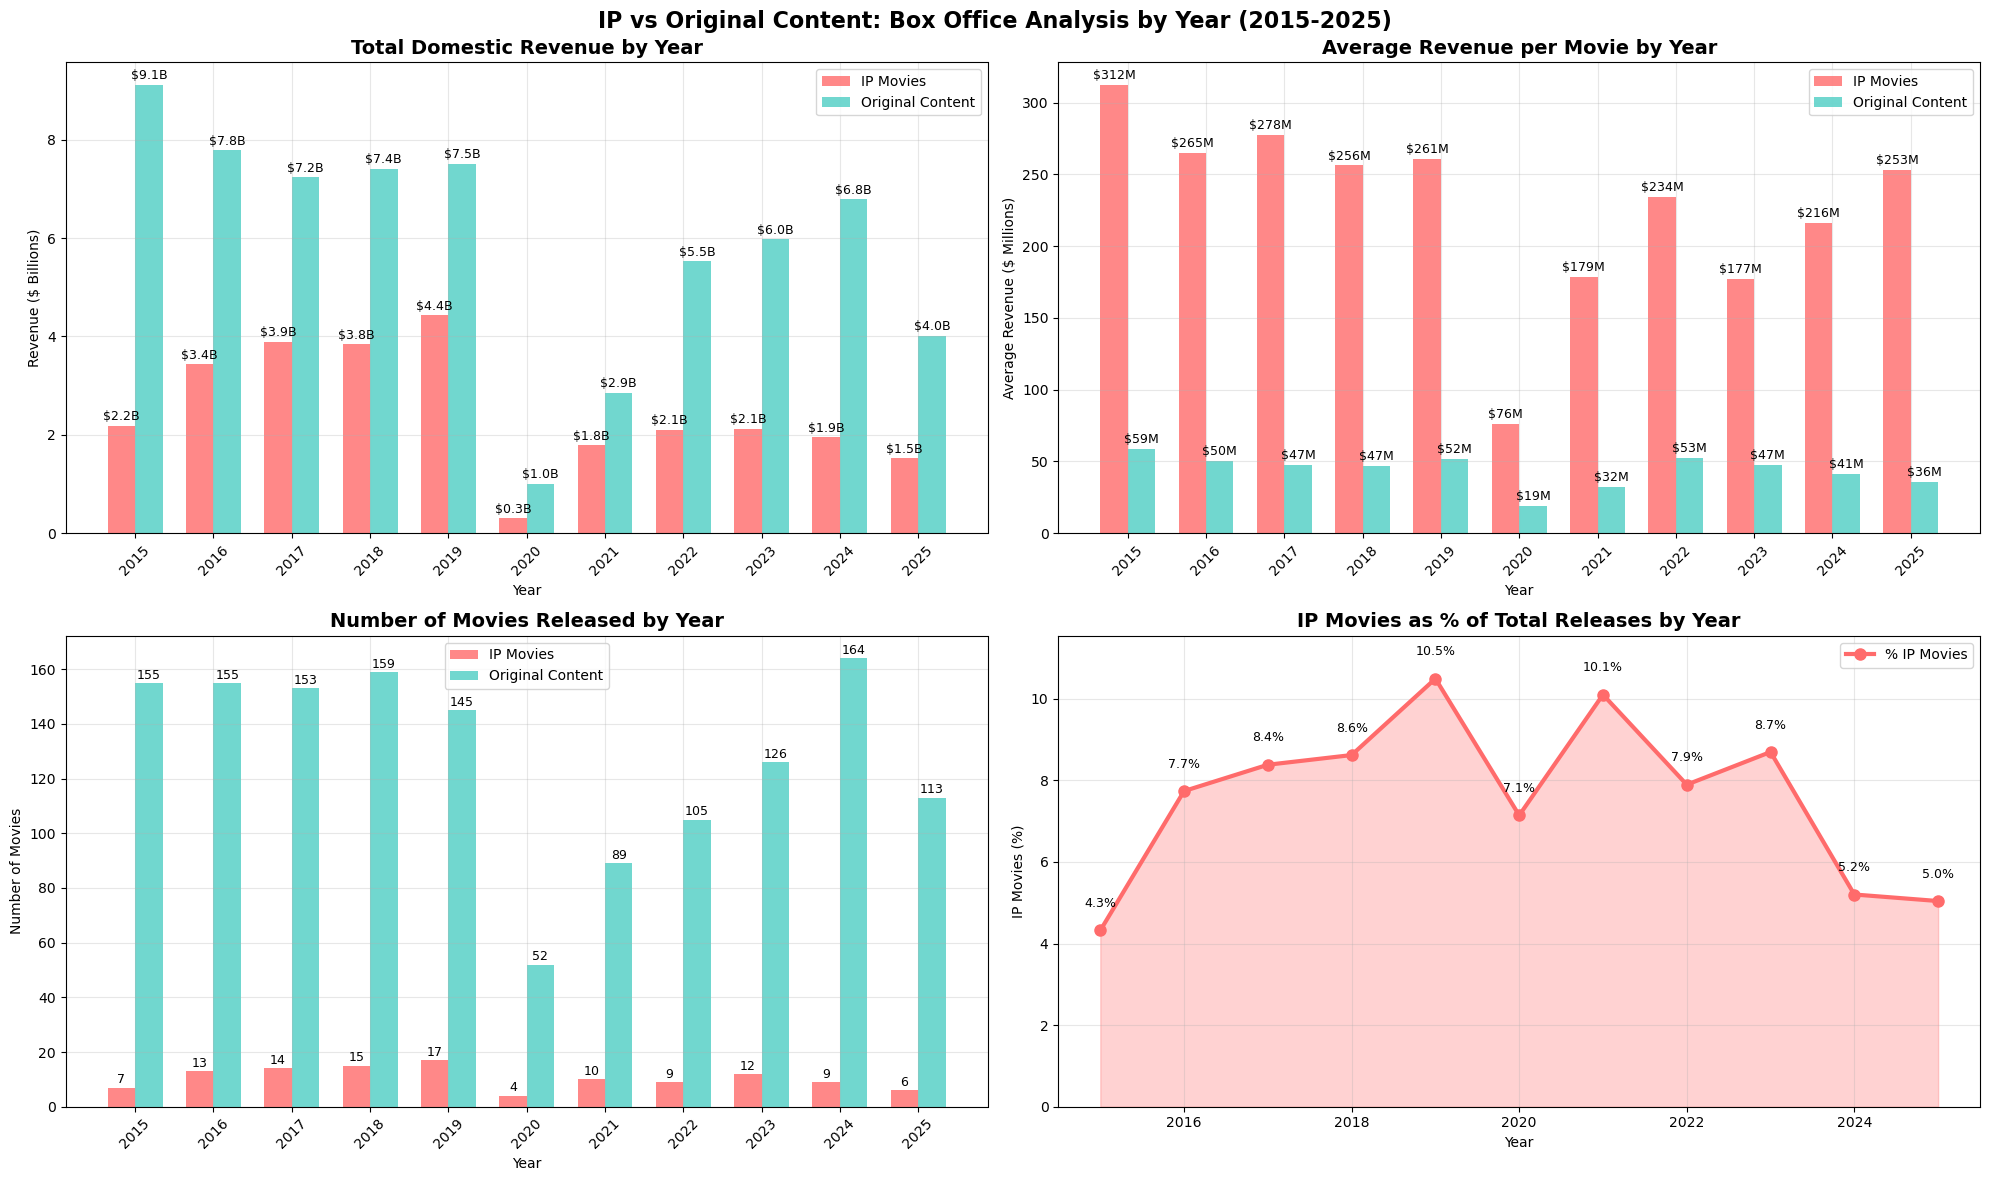


🎬 IP vs Original Content Analysis (2015-2025):

Overall Statistics:
Total IP movies: 116 (7.6%)
Total original content: 1,416 (92.4%)
IP total revenue: $27.57B (29.7%)
Original total revenue: $65.23B (70.3%)

Average Revenue per Movie:
IP movies: $237.7M
Original content: $46.1M
IP advantage: 416%

Year-over-Year Trends:
------------------------------
IP percentage range: 4.3% - 10.5%
Highest IP year: 2019 (10.5%)
Lowest IP year: 2015 (4.3%)
Best IP revenue year: 2019.0 ($4.4B)
Best original revenue year: 2015.0 ($9.1B)


In [16]:
### IP vs Original Content Analysis by Year

# Create yearly comparison data
years = sorted(df['release_year'].unique())
ip_vs_original_data = []

for year in years:
    year_data = df[df['release_year'] == year]
    
    # IP movies stats
    ip_movies = year_data[year_data['is_ip_movie'] == 1]
    ip_count = len(ip_movies)
    ip_total_revenue = ip_movies['revenue_domestic'].sum()
    ip_avg_revenue = ip_movies['revenue_domestic'].mean() if ip_count > 0 else 0
    
    # Original content stats
    original_movies = year_data[year_data['is_ip_movie'] == 0]
    original_count = len(original_movies)
    original_total_revenue = original_movies['revenue_domestic'].sum()
    original_avg_revenue = original_movies['revenue_domestic'].mean() if original_count > 0 else 0
    
    ip_vs_original_data.append({
        'year': year,
        'ip_count': ip_count,
        'original_count': original_count,
        'ip_total_revenue': ip_total_revenue,
        'original_total_revenue': original_total_revenue,
        'ip_avg_revenue': ip_avg_revenue,
        'original_avg_revenue': original_avg_revenue,
        'total_movies': ip_count + original_count,
        'ip_percentage': (ip_count / (ip_count + original_count) * 100) if (ip_count + original_count) > 0 else 0
    })

ip_df = pd.DataFrame(ip_vs_original_data)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('IP vs Original Content: Box Office Analysis by Year (2015-2025)', fontsize=16, fontweight='bold')

# Color scheme
ip_color = '#FF6B6B'      # Red for IP
original_color = '#4ECDC4' # Teal for Original

# 1. Total Revenue Comparison
ax1 = axes[0, 0]
x = np.arange(len(years))
width = 0.35

bars1 = ax1.bar(x - width/2, ip_df['ip_total_revenue'] / 1e9, width, 
               label='IP Movies', color=ip_color, alpha=0.8)
bars2 = ax1.bar(x + width/2, ip_df['original_total_revenue'] / 1e9, width,
               label='Original Content', color=original_color, alpha=0.8)

ax1.set_title('Total Domestic Revenue by Year', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue ($ Billions)')
ax1.set_xticks(x)
ax1.set_xticklabels(years, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'${height:.1f}B', ha='center', va='bottom', fontsize=9)

# 2. Average Revenue per Movie
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, ip_df['ip_avg_revenue'] / 1e6, width,
               label='IP Movies', color=ip_color, alpha=0.8)
bars4 = ax2.bar(x + width/2, ip_df['original_avg_revenue'] / 1e6, width,
               label='Original Content', color=original_color, alpha=0.8)

ax2.set_title('Average Revenue per Movie by Year', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Revenue ($ Millions)')
ax2.set_xticks(x)
ax2.set_xticklabels(years, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'${height:.0f}M', ha='center', va='bottom', fontsize=9)

# 3. Movie Count Comparison
ax3 = axes[1, 0]
bars5 = ax3.bar(x - width/2, ip_df['ip_count'], width,
               label='IP Movies', color=ip_color, alpha=0.8)
bars6 = ax3.bar(x + width/2, ip_df['original_count'], width,
               label='Original Content', color=original_color, alpha=0.8)

ax3.set_title('Number of Movies Released by Year', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Number of Movies')
ax3.set_xticks(x)
ax3.set_xticklabels(years, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add value labels
for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 4. IP Percentage Over Time
ax4 = axes[1, 1]
line = ax4.plot(years, ip_df['ip_percentage'], marker='o', linewidth=3, 
                markersize=8, color=ip_color, label='% IP Movies')
ax4.fill_between(years, ip_df['ip_percentage'], alpha=0.3, color=ip_color)

ax4.set_title('IP Movies as % of Total Releases by Year', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('IP Movies (%)')
ax4.set_ylim(0, max(ip_df['ip_percentage']) * 1.1)
ax4.grid(True, alpha=0.3)
ax4.legend()

# Add value labels on line
for i, (year, pct) in enumerate(zip(years, ip_df['ip_percentage'])):
    ax4.text(year, pct + 0.5, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n🎬 IP vs Original Content Analysis ({min(years)}-{max(years)}):")
print("=" * 60)

total_ip = df['is_ip_movie'].sum()
total_original = len(df) - total_ip
total_ip_revenue = df[df['is_ip_movie'] == 1]['revenue_domestic'].sum()
total_original_revenue = df[df['is_ip_movie'] == 0]['revenue_domestic'].sum()

print(f"\nOverall Statistics:")
print(f"Total IP movies: {total_ip:,} ({total_ip/len(df)*100:.1f}%)")
print(f"Total original content: {total_original:,} ({total_original/len(df)*100:.1f}%)")
print(f"IP total revenue: ${total_ip_revenue/1e9:.2f}B ({total_ip_revenue/(total_ip_revenue+total_original_revenue)*100:.1f}%)")
print(f"Original total revenue: ${total_original_revenue/1e9:.2f}B ({total_original_revenue/(total_ip_revenue+total_original_revenue)*100:.1f}%)")

avg_ip = df[df['is_ip_movie'] == 1]['revenue_domestic'].mean()
avg_original = df[df['is_ip_movie'] == 0]['revenue_domestic'].mean()
print(f"\nAverage Revenue per Movie:")
print(f"IP movies: ${avg_ip/1e6:.1f}M")
print(f"Original content: ${avg_original/1e6:.1f}M")
print(f"IP advantage: {(avg_ip/avg_original - 1)*100:.0f}%")

# Year-over-year trends
print(f"\nYear-over-Year Trends:")
print("-" * 30)
print(f"IP percentage range: {ip_df['ip_percentage'].min():.1f}% - {ip_df['ip_percentage'].max():.1f}%")
print(f"Highest IP year: {ip_df.loc[ip_df['ip_percentage'].idxmax(), 'year']} ({ip_df['ip_percentage'].max():.1f}%)")
print(f"Lowest IP year: {ip_df.loc[ip_df['ip_percentage'].idxmin(), 'year']} ({ip_df['ip_percentage'].min():.1f}%)")

# Best performing years
best_ip_revenue_year = ip_df.loc[ip_df['ip_total_revenue'].idxmax()]
best_original_revenue_year = ip_df.loc[ip_df['original_total_revenue'].idxmax()]
print(f"Best IP revenue year: {best_ip_revenue_year['year']} (${best_ip_revenue_year['ip_total_revenue']/1e9:.1f}B)")
print(f"Best original revenue year: {best_original_revenue_year['year']} (${best_original_revenue_year['original_total_revenue']/1e9:.1f}B)")

## Live-Action Remakes and Adaptations

In [17]:
# Create live-action remake and adaptation features (using imported lists)
print("Creating remake/adaptation features...")

# Live-action remakes (Disney + DreamWorks + others - exact matching first, then patterns)
df['is_live_action_remake'] = df['title'].isin(ALL_LIVE_ACTION_REMAKES).astype(int)
# Add pattern matching for titles that might be formatted differently
for pattern in REMAKE_PATTERNS['live_action_remakes']:
    matches = df['title'].str.contains(pattern, case=False, na=False)
    df.loc[matches, 'is_live_action_remake'] = 1

# Other media adaptations (using imported list + patterns)
df['is_adaptation'] = df['title'].isin(MEDIA_ADAPTATIONS).astype(int)
for pattern in REMAKE_PATTERNS['other_adaptations']:
    matches = df['title'].str.contains(pattern, case=False, na=False)
    df.loc[matches, 'is_adaptation'] = 1

# Superhero movies (combining all superhero films)
df['is_superhero'] = df['title'].isin(ALL_SUPERHERO_FILMS).astype(int)
for pattern in REMAKE_PATTERNS['superhero']:
    matches = df['title'].str.contains(pattern, case=False, na=False)
    df.loc[matches, 'is_superhero'] = 1

# General remake indicators (using imported list)
df['has_remake_indicator'] = df['title'].str.contains('|'.join(REMAKE_TITLE_INDICATORS), case=False, na=False).astype(int)

# Combined remake/adaptation feature
df['is_remake_adaptation'] = (df['is_live_action_remake'] | df['is_adaptation'] | 
                              df['has_remake_indicator']).astype(int)

# Summary
print(f"Live-action remakes: {df['is_live_action_remake'].sum()}")
print(f"Media adaptations: {df['is_adaptation'].sum()}")
print(f"Superhero movies: {df['is_superhero'].sum()}")
print(f"Remake title indicators: {df['has_remake_indicator'].sum()}")
print(f"Total remakes/adaptations: {df['is_remake_adaptation'].sum()} ({df['is_remake_adaptation'].mean()*100:.1f}%)")

# Performance comparison
if df['is_remake_adaptation'].sum() > 0:
    remake_avg = df[df['is_remake_adaptation'] == 1]['revenue_domestic'].mean()
    original_avg = df[df['is_remake_adaptation'] == 0]['revenue_domestic'].mean()
    print(f"\nAverage revenue - Remakes/Adaptations: ${remake_avg:,.0f}")
    print(f"Average revenue - Original content: ${original_avg:,.0f}")
    print(f"Remake advantage: {(remake_avg/original_avg - 1)*100:.1f}%")

# Live-action remake performance comparison
if df['is_live_action_remake'].sum() > 0:
    remake_avg = df[df['is_live_action_remake'] == 1]['revenue_domestic'].mean()
    non_remake_avg = df[df['is_live_action_remake'] == 0]['revenue_domestic'].mean()
    print(f"\nAverage revenue - Live-action remakes: ${remake_avg:,.0f}")
    print(f"Average revenue - Non-remakes: ${non_remake_avg:,.0f}")
    print(f"Live-action remake advantage: {(remake_avg/non_remake_avg - 1)*100:.1f}%")

# Superhero performance comparison
if df['is_superhero'].sum() > 0:
    superhero_avg = df[df['is_superhero'] == 1]['revenue_domestic'].mean()
    non_superhero_avg = df[df['is_superhero'] == 0]['revenue_domestic'].mean()
    print(f"\nAverage revenue - Superhero movies: ${superhero_avg:,.0f}")
    print(f"Average revenue - Non-superhero movies: ${non_superhero_avg:,.0f}")
    print(f"Superhero advantage: {(superhero_avg/non_superhero_avg - 1)*100:.1f}%")

Creating remake/adaptation features...
Live-action remakes: 18
Media adaptations: 17
Superhero movies: 63
Remake title indicators: 9
Total remakes/adaptations: 41 (2.7%)

Average revenue - Remakes/Adaptations: $179,729,228
Average revenue - Original content: $57,301,301
Remake advantage: 213.7%

Average revenue - Live-action remakes: $269,489,612
Average revenue - Non-remakes: $58,094,006
Live-action remake advantage: 363.9%

Average revenue - Superhero movies: $260,939,609
Average revenue - Non-superhero movies: $51,984,985
Superhero advantage: 402.0%


### Revenue Analysis

In [18]:
# Revenue analysis - using domestic revenue
has_revenue = df['revenue_domestic'] > 0
print(f"Movies with domestic revenue data: {has_revenue.sum()} out of {len(df)} ({has_revenue.mean()*100:.1f}%)")

print("\nTop 10 highest grossing movies (domestic):")
top_movies = df[has_revenue].nlargest(10, 'revenue_domestic')[['title', 'revenue_domestic', 'distributor']]
print(top_movies.to_string())

print("\nRevenue by major distributors:")
# Get top distributors
top_distributors = df[has_revenue]['distributor'].value_counts().head(8).index.tolist()
major_distributor_movies = df[(df['revenue_domestic'] > 0) & (df['distributor'].isin(top_distributors))]

if len(major_distributor_movies) > 0:
    revenue_by_distributor = major_distributor_movies.groupby('distributor')['revenue_domestic'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    print(revenue_by_distributor)
else:
    print("No major distributor movies with revenue data found")

Movies with domestic revenue data: 1532 out of 1532 (100.0%)

Top 10 highest grossing movies (domestic):
                             title  revenue_domestic                          distributor
6     Star Wars: The Force Awakens       936662225.0  Walt Disney Studios Motion Pictures
672              Avengers: Endgame       858373000.0  Walt Disney Studios Motion Pictures
889        Spider-Man: No Way Home       814866759.0              Sony Pictures Releasing
990              Top Gun: Maverick       718732821.0                   Paramount Pictures
498                  Black Panther       700426566.0  Walt Disney Studios Motion Pictures
988       Avatar: The Way of Water       684075767.0                 20th Century Studios
497         Avengers: Infinity War       678815482.0  Walt Disney Studios Motion Pictures
3                   Jurassic World       653406625.0                   Universal Pictures
1243                  Inside Out 2       652980194.0  Walt Disney Studios Motion Pict

## Final Dataset Summary

In [19]:
# Feature summary
binary_features = [col for col in df.columns if col.startswith('is_')]
print(f"Domestic Box Office Dataset:")
print(f"Dataset shape: {df.shape}")
print(f"Binary features created: {len(binary_features)}")

print("\nFeature summary:")
for feature in binary_features:
    count = df[feature].sum()
    if count > 5:  # Lower threshold since smaller dataset
        print(f"{feature}: {count} ({count/len(df)*100:.1f}%)")

# Save processed dataset
df.to_csv("../data/dataset_domestic_processed.csv", index=False)
print(f"\n✅ Processed domestic dataset saved with {df.shape[1]} features")
print(f"🎯 All analysis now uses US domestic box office revenue!")

Domestic Box Office Dataset:
Dataset shape: (1532, 68)
Binary features created: 25

Feature summary:
is_disney: 86 (5.6%)
is_warner_bros: 145 (9.5%)
is_universal: 168 (11.0%)
is_sony: 150 (9.8%)
is_paramount: 88 (5.7%)
is_fox: 99 (6.5%)
is_mgm: 39 (2.5%)
is_lionsgate: 116 (7.6%)
is_major_studio: 891 (58.2%)
is_action_adventure: 178 (11.6%)
is_action_sci_fi: 123 (8.0%)
is_comedy_romance: 63 (4.1%)
is_family_animation: 111 (7.2%)
is_sequel_title: 228 (14.9%)
is_marvel: 26 (1.7%)
is_dc: 13 (0.8%)
is_sequel: 256 (16.7%)
is_live_action_remake: 18 (1.2%)
is_adaptation: 17 (1.1%)
is_superhero: 63 (4.1%)
is_remake_adaptation: 41 (2.7%)
is_ip_movie: 116 (7.6%)

✅ Processed domestic dataset saved with 68 features
🎯 All analysis now uses US domestic box office revenue!
